# ***Check GPU connect***

In [2]:
print("oke nice")

oke nice


In [3]:
import torch 

print(torch.__version__) 
print(torch.cuda.is_available()) 
print(torch.cuda.get_device_name(0))

2.4.0
True
Tesla T4


In [4]:
!nvidia-smi

Thu Sep 12 11:57:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             12W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# ***Content***

## Clone dataset 

In [5]:
!pip install gdown

In [6]:
!git clone https://github.com/QuanHoangNgoc/data-temp.git

fatal: destination path 'data-temp' already exists and is not an empty directory.


## Install

In [7]:
# !pip -q install sentence-transformers
!pip -q install faiss-gpu

In [8]:
import os
from PIL import Image
import numpy as np
import faiss
# from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random

## Check dataset and create image_files 

In [9]:
def get_imagelist(root_folder, glob="jpg"): 
    paths = []
    for dirpath, dirnames, filenames in sorted(os.walk(root_folder)): #!!! must sorted 
        for file in filenames:  
            fullpath = os.path.join(dirpath, file)
            if(fullpath.split(".")[-1] != glob): continue
            paths.append(fullpath) 
    return paths

18148 ['/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_100.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_199.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_80.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_230.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_78.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_147.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_148.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_107.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_244.jpg', '/kaggle/working/data-temp/Keyframes_L07/L07_V001/L07_V001_250.jpg']


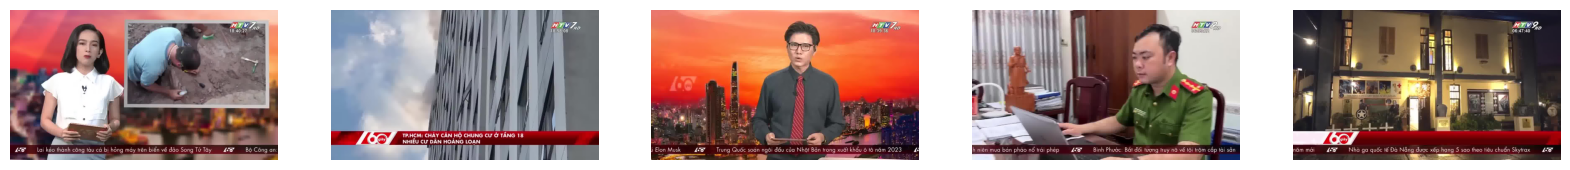

In [10]:
image_folder = "/kaggle/working/data-temp"

image_files = get_imagelist(image_folder)
print(len(image_files), image_files[:10]) 
selected_files = random.sample(image_files, 5)

plt.figure(figsize=(20, 5))

for i, file in enumerate(selected_files):
    image = Image.open(file)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

## Create embeddings and meta 

In [11]:
# # new a embedding model 
# model = SentenceTransformer('clip-ViT-B-32')

# CHUNK_SIZE = 256

# # process each chunk 
# def process_chunk(chunk):
#     images = []
#     for image_file in chunk: images.append(Image.open(image_file))

#     chunk_embeddings = model.encode(images)
#     return chunk_embeddings


# # create the embeddings 
# embeddings = []
# for i in range(0, len(image_files), CHUNK_SIZE):
#     print(i)
#     chunk = image_files[i:i + CHUNK_SIZE]
#     embeddings.extend(process_chunk(chunk))
    
# embeddings 

In [12]:
import gdown  

def drive_down(file_id, name_output_file): 
    url = f'https://drive.google.com/uc?id={file_id}'  
    output = name_output_file  
    gdown.download(url, output, quiet=False)

### clone embedding 

In [13]:
file_id = '1AnwmsgIlTZ6yROoG-sAHXyyviSiDXAxd' 
drive_down(file_id, "emb.npy")

Downloading...
From (original): https://drive.google.com/uc?id=1AnwmsgIlTZ6yROoG-sAHXyyviSiDXAxd
From (redirected): https://drive.google.com/uc?id=1AnwmsgIlTZ6yROoG-sAHXyyviSiDXAxd&confirm=t&uuid=021d1c95-39f4-4861-8ac3-e3ae3032b06c
To: /kaggle/working/emb.npy
100%|██████████| 448M/448M [00:02<00:00, 173MB/s]  


In [14]:
embeddings = np.load('emb.npy')

In [15]:
embeddings.shape 

(109419, 1024)

### clone meta

In [16]:
file_id = '16vgOEJMksbsjFuRjo0MDpDCBsLh0FpWE'
drive_down(file_id, "meta.pkl")

Downloading...
From: https://drive.google.com/uc?id=16vgOEJMksbsjFuRjo0MDpDCBsLh0FpWE
To: /kaggle/working/meta.pkl
100%|██████████| 2.04M/2.04M [00:00<00:00, 137MB/s]


In [17]:
import pickle

with open('meta.pkl', 'rb') as file:
    meta = pickle.load(file)

In [18]:
print(type(meta), len(meta), meta[:10])

<class 'list'> 109419 ['L01_V001_1.jpg', 'L01_V001_2.jpg', 'L01_V001_3.jpg', 'L01_V001_4.jpg', 'L01_V001_5.jpg', 'L01_V001_6.jpg', 'L01_V001_7.jpg', 'L01_V001_8.jpg', 'L01_V001_9.jpg', 'L01_V001_10.jpg']


## Create database 

In [19]:
# build vector db 
dimension = len(embeddings[0])
db = faiss.IndexFlatIP(dimension)
db = faiss.IndexIDMap(db)

# insert embeddings into database 
vectors = np.array(embeddings).astype('float32')
db.add_with_ids(vectors, np.array(range(len(embeddings))))

In [20]:
db

<faiss.swigfaiss.IndexIDMap; proxy of <Swig Object of type 'faiss::IndexIDMapTemplate< faiss::Index > *' at 0x7ec90c12ad90> >

## Search

In [21]:
!pip install sentence-transformers==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 817.7 kB/s eta 0:00:00 0:00:01m
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=68e96dbfd4e482eb2d831ef16fb0b6e1057ad307e6076e910eedfae7945d5c16
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [22]:
!pip install torchscale

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 7.4 MB/s eta 0:00:0000:01:00:01
  Created wheel for fairscale: filename=fairscale-0.4.0-py3-none-any.whl size=239917 sha256=eb1c9288c60b66619a764ef1b745b39be04f97a87b0473125e2b58a3edf071a1
  Stored in directory: /root/.cache/pip/wheels/5e/3d/e9/3995d67ff23a09f72bba6380efb35ba97091c7932748884c41
Successfully built fairscale
  Attempting uninstall: timm
    Found existing installation: timm 1.0.8
    Uninstalling timm-1.0.8:
      Successfully uninstalled timm-1.0.8


In [23]:
file_id = '1Xf3XDVR59ONPNemQ0URS7-djDGssfXaN'
drive_down(file_id, "beit3.zip")

Downloading...
From: https://drive.google.com/uc?id=1Xf3XDVR59ONPNemQ0URS7-djDGssfXaN
To: /kaggle/working/beit3.zip
100%|██████████| 708k/708k [00:00<00:00, 108MB/s]


In [24]:
!unzip beit3.zip

Archive:  beit3.zip
replace BEiT3/beit3.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [24]:
os.listdir('/kaggle/working/BEiT3/checkpoints')

['beit3.spm']

In [25]:
file_id = '1e8qULfZLu26e8-wHdtJxCC6wfG72IWMp'
drive_down(file_id, "beit3.pth")

Downloading...
From (original): https://drive.google.com/uc?id=1e8qULfZLu26e8-wHdtJxCC6wfG72IWMp
From (redirected): https://drive.google.com/uc?id=1e8qULfZLu26e8-wHdtJxCC6wfG72IWMp&confirm=t&uuid=8fe23241-8a4a-4cf6-81cf-7509d77ebcaf
To: /kaggle/working/beit3.pth
100%|██████████| 1.35G/1.35G [00:26<00:00, 51.3MB/s]


In [26]:
import BEiT3.beit3 as module

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = "beit3.pth"
sentencepiece_model = os.path.join('/kaggle/working/BEiT3/checkpoints', 'beit3.spm')

In [28]:
model, transform, tokenizer = module.load_model(device, checkpoint, sentencepiece_model)

/kaggle/working/BEiT3/utils_beit.py:526: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


Load ckpt from beit3.pth
Load state_dict by model_key = model


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [34]:
!pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.0 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16353 sha256=53bcafbcc96e25b8def3ca7748132a6a07b738b2d22dd70cbe791987252185d0
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0

In [39]:
from googletrans import Translator
translator = Translator()

def search_image(query, db, meta, top_k=100):
    # Query can be image-path or text
    if query.endswith(".jpg"): query = Image.open(query) #!!! not process with image 
    
    text = translator.translate(query, dest='en').text
    emb = module.encode_text(model, tokenizer, text, device)
    print(text, emb.shape)
    concat_emb = emb.astype("float32").reshape(1, -1)
    distances, indices = db.search(concat_emb, top_k)

    retrieved_meta = [meta[i] for i in indices[0]]
    return query, retrieved_meta

In [40]:
query = "Một con thuyền chạy được trên băng, màu đen. Con thuyền này chạy bằng động cơ cánh quạt ở bên trên thổi hướng ra phía sau. Con thuyền là phương tiện hỗ trợ cứu hộ một nạn nhân bị rơi xuống hồ băng."
search_image(query, db, meta, top_k=100)

A boat that can run on ice, black in color. This boat is powered by a propeller engine on top that blows out the back. The boat was a rescue vehicle for a victim who fell into an icy lake. (1, 1024)


('Một con thuyền chạy được trên băng, màu đen. Con thuyền này chạy bằng động cơ cánh quạt ở bên trên thổi hướng ra phía sau. Con thuyền là phương tiện hỗ trợ cứu hộ một nạn nhân bị rơi xuống hồ băng.',
 ['L09_V017_217.jpg',
  'L09_V017_216.jpg',
  'L09_V017_215.jpg',
  'L09_V017_214.jpg',
  'L09_V017_200.jpg',
  'L09_V017_207.jpg',
  'L09_V017_213.jpg',
  'L09_V017_212.jpg',
  'L09_V001_218.jpg',
  'L09_V028_289.jpg',
  'L10_V017_113.jpg',
  'L09_V028_290.jpg',
  'L06_V026_313.jpg',
  'L10_V022_209.jpg',
  'L07_V031_242.jpg',
  'L04_V027_106.jpg',
  'L10_V002_179.jpg',
  'L03_V027_194.jpg',
  'L06_V026_314.jpg',
  'L06_V005_197.jpg',
  'L04_V018_144.jpg',
  'L06_V026_315.jpg',
  'L02_V009_253.jpg',
  'L06_V026_312.jpg',
  'L12_V025_193.jpg',
  'L04_V014_50.jpg',
  'L06_V005_187.jpg',
  'L09_V017_206.jpg',
  'L03_V007_243.jpg',
  'L09_V017_209.jpg',
  'L08_V023_149.jpg',
  'L10_V017_128.jpg',
  'L08_V017_7.jpg',
  'L12_V010_187.jpg',
  'L07_V031_200.jpg',
  'L10_V009_162.jpg',
  'L09_V0

In [50]:
import shutil, csv

def main_submit(in_folder, out_folder="submit"):
    out_folder = os.path.join(os.getcwd(), out_folder)
    if os.path.exists(out_folder): shutil.rmtree(out_folder)
    os.makedirs(out_folder, exist_ok=True)
    print(f"Remove and renew {out_folder}")
    
    for namefile in os.listdir(in_folder):
        with open(os.path.join(in_folder, namefile), 'r') as file:
            # Read the entire file content
            content = file.read()
            
            # Get answer list 
            _, lst = search_image(content, db, meta, top_k=100)
            new_list = [] 
            for x in lst: 
                frame_idx = int(x.split('_')[-1].split('.')[0]) * 100 - 100 
                video = x.split('_')[0] + '_' + x.split('_')[1]
                new_list.append([video, frame_idx])
            
            # Write file csv 
            path = os.path.join(out_folder, namefile.replace(".txt", ".csv"))
            with open(path, 'w', newline='') as csvfile:
                # Create a CSV writer object
                writer = csv.writer(csvfile)
    
                # Write the data to the CSV file
                writer.writerows(new_list) 

In [51]:
in_folder = '/kaggle/input/query-aic/pack-pretest'
main_submit(in_folder)

Remove and renew /kaggle/working/submit
A boat that can run on ice, black in color. This boat is powered by a propeller engine on top that blows out the back. The boat was a rescue vehicle for a victim who fell into an icy lake. (1, 1024)
A doctor/nurse is examining a patient's eyes using a machine called CLARUS. The patient wears a blue shirt. Ends with the scene of the doctor/nurse's hand adjusting the joystick with a glowing blue circle. What is the number recorded on the CLARUS machine? (1, 1024)
The scene begins with a scene in the supermarket in the area where bags of rice are sold. Ending at the scene of the "Neptune" brand Japonica rice bag, there is a price sign next to it. Ask what percentage discount is on this product (numbers only)? (1, 1024)
A person is being interviewed. The wall behind this person is hung with many shark teeth. (1, 1024)
The scene is in an office room, with a round table in the middle and a circular table surrounding it. Many people are sitting and work

In [52]:
# Specify the folder to compress and the output ZIP file name  
folder_to_compress = '/kaggle/working/submit' 
output_zip_file = 'submit.zip'  

# Compress the runs to zip 
shutil.make_archive(output_zip_file.replace('.zip', ''), 'zip', folder_to_compress)

'/kaggle/working/submit.zip'